In [2]:
import numpy as np
import matplotlib.pyplot as plt
from enspara import ra, msm
import deeptime
from deeptime.markov import TransitionCountEstimator
from deeptime.markov.msm import MaximumLikelihoodMSM
from deeptime.plots import plot_implied_timescales
from deeptime.util.validation import implied_timescales
import json

INFO:numexpr.utils:Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [3]:
def load_and_plot_its(ra_fn, ax, rep, tl, k, n_its=4, lags=np.geomspace(20, 5000, num=20).astype(int), resect_fraction=1.0):
    assigns = ra.load(ra_fn)
    lengths = assigns.lengths
    dtrajs = list(dtraj.astype(int) for dtraj in assigns)
    models = []
    for lag in lags:
        counts = TransitionCountEstimator(
            lagtime=lag, count_mode='sliding').fit_fetch(dtrajs)
        models.append(MaximumLikelihoodMSM().fit_fetch(counts))
    its_data = implied_timescales(models, n_its=n_its)
    plot_implied_timescales(its_data, n_its=n_its, ax=ax)
    ax.set_yscale('log')
    ax.set_title(f'k: {k}, tl: {tl}, rep: {rep},\n lengths: {lengths}')
    ax.set_xlabel('lag time (steps)')
    ax.set_ylabel('timescale (steps)')
    return (dtrajs, models, its_data)

def deeptime_mapping_to_mapped_dict(model):
    sym = model.state_symbols(0)
    to_mapped = {int(x):i for i,x in enumerate(sym)}
    return to_mapped


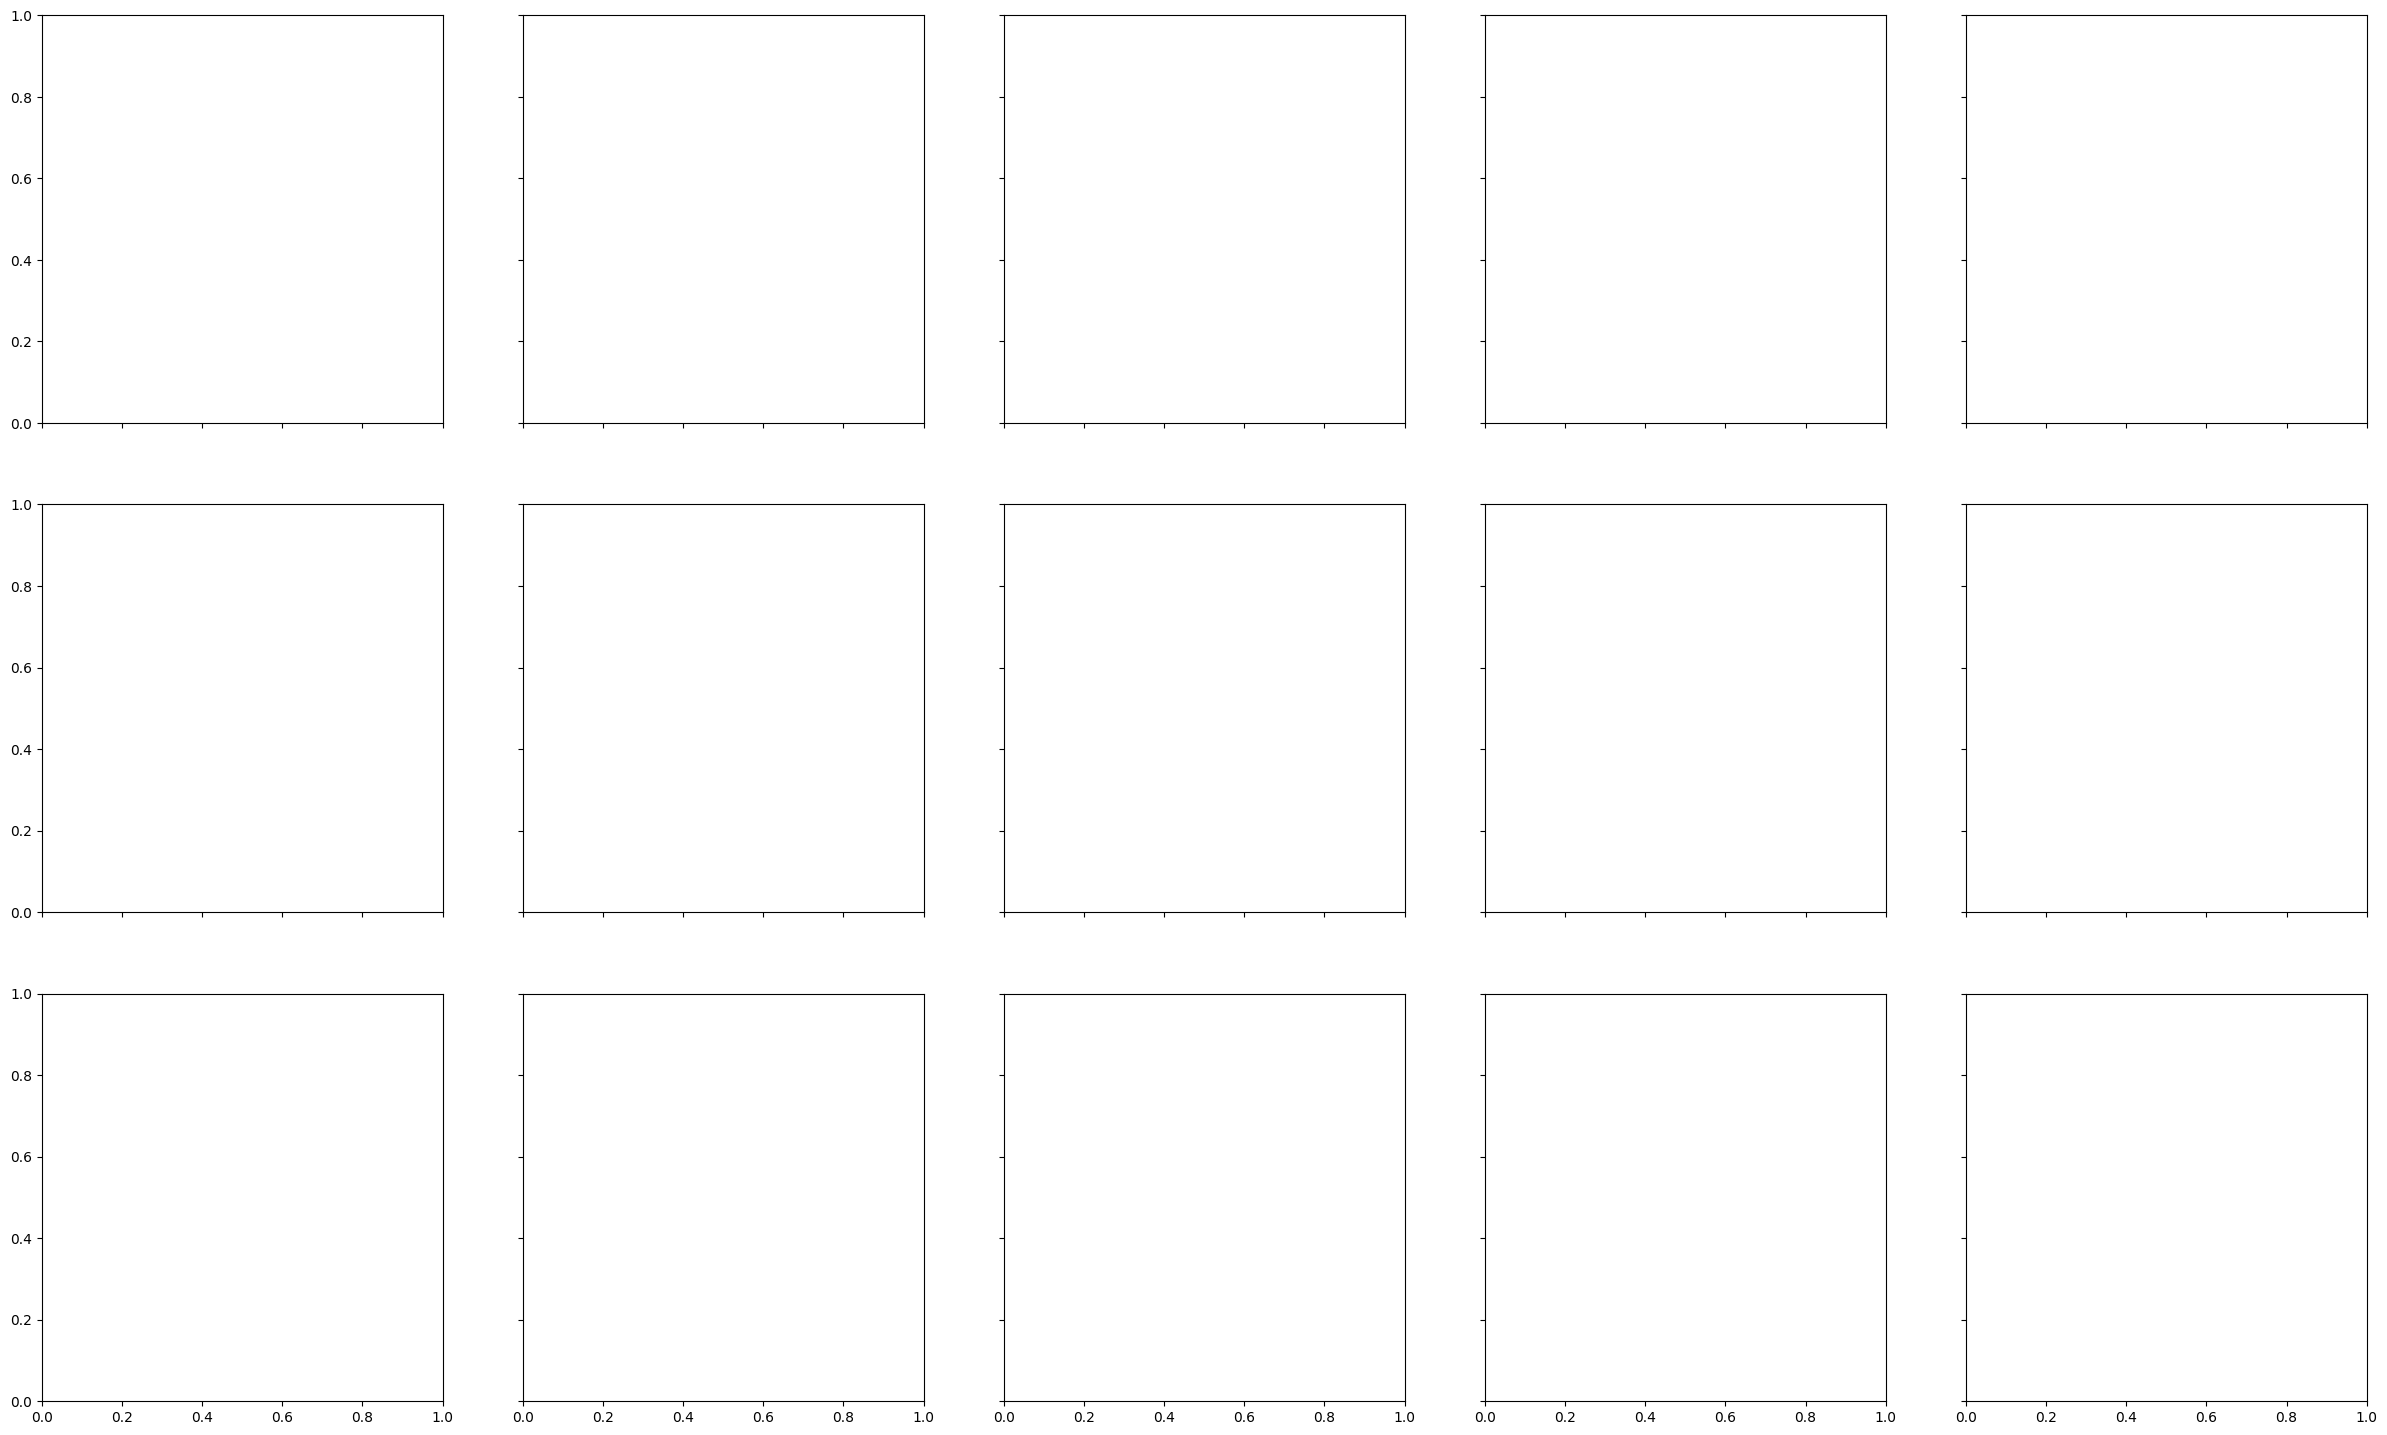

In [4]:

fig, axs = plt.subplots(3,5, figsize=(30, 18), sharex=True, sharey=True)
k = 25  
tl = 500
resects = np.linspace(0.2, 1, 5)
# for i, rep in enumerate([1,2,3]): 
#     for j, resect_to_frac in enumerate(resects):
#         ax = axs[i, j]
#         dtrajs, models, its_data = load_and_plot_its(
#             f't4l-{rep}/clustering/resect-{resect_to_frac:.1f}/t4l-{rep}-backbone-all-chis-dihedrals-pocket-tica-lag-{tl}-tica-reduced-k-{k}-dtrajs.h5',
#             ax,
#             rep,
#             tl,
#             k
#         )

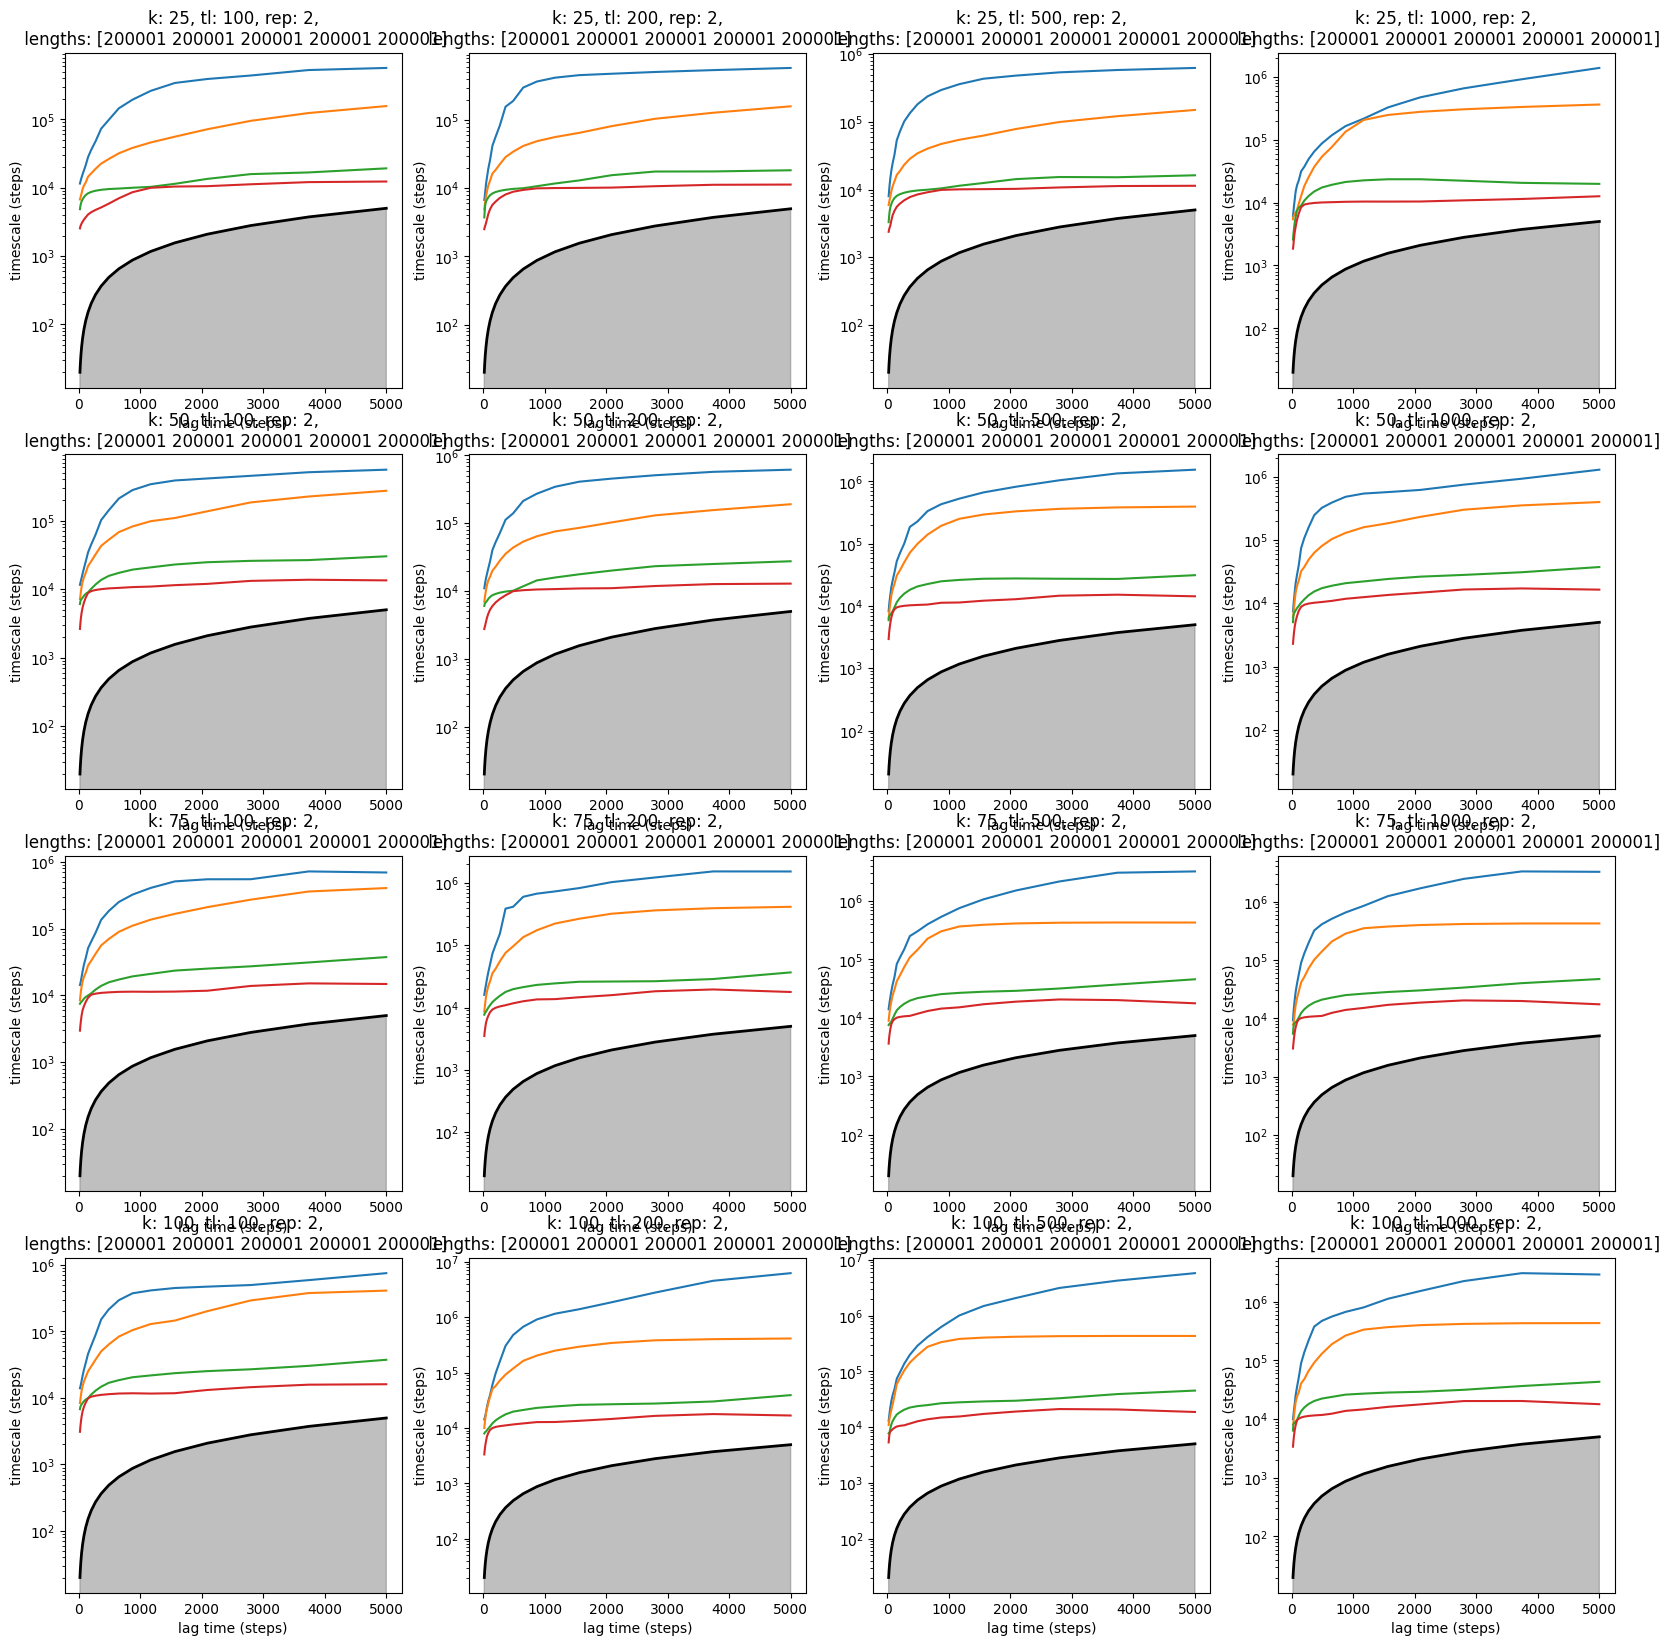

In [4]:
rep=2
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
for i, k in enumerate([25, 50, 75, 100]):
    for j, tl in enumerate([100, 200, 500, 1000]):
        ax = axs[i, j]
        dtrajs, models, its_data = load_and_plot_its(
            f't4l-{rep}/clustering/t4l-{rep}-backbone-all-chis-dihedrals-pocket-tica-lag-{tl}-tica-reduced-k-{k}-dtrajs.h5',
            ax,
            rep,
            tl,
            k
        )

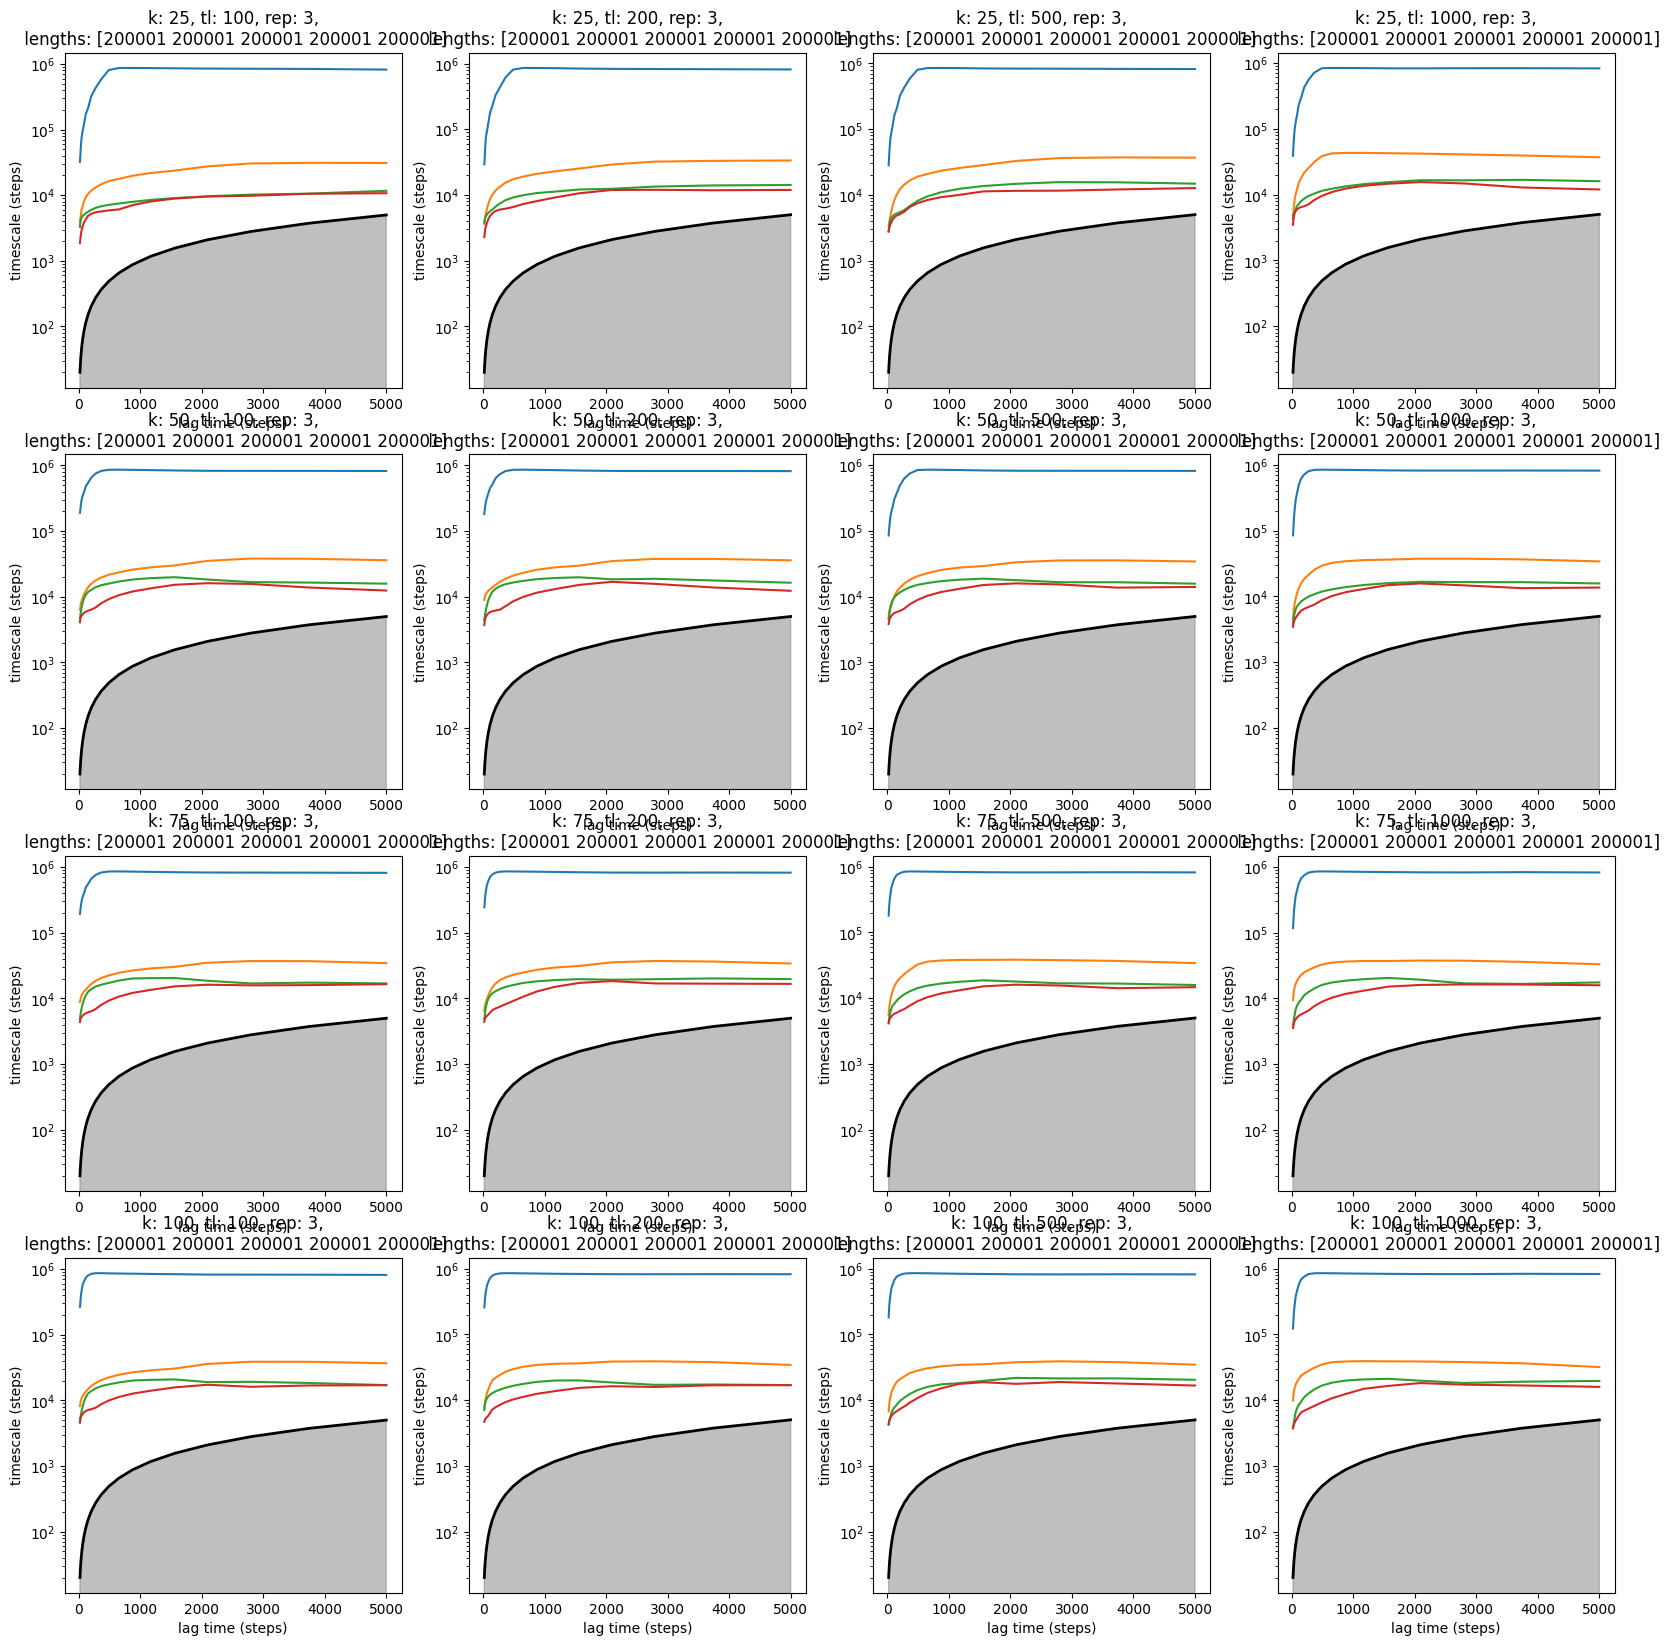

In [5]:
rep=3
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
for i, k in enumerate([25, 50, 75, 100]):
    for j, tl in enumerate([100, 200, 500, 1000]):
        ax = axs[i, j]
        dtrajs, models, its_data = load_and_plot_its(
            f't4l-{rep}/clustering/t4l-{rep}-backbone-all-chis-dihedrals-pocket-tica-lag-{tl}-tica-reduced-k-{k}-dtrajs.h5',
            ax,
            rep,
            tl,
            k
        )

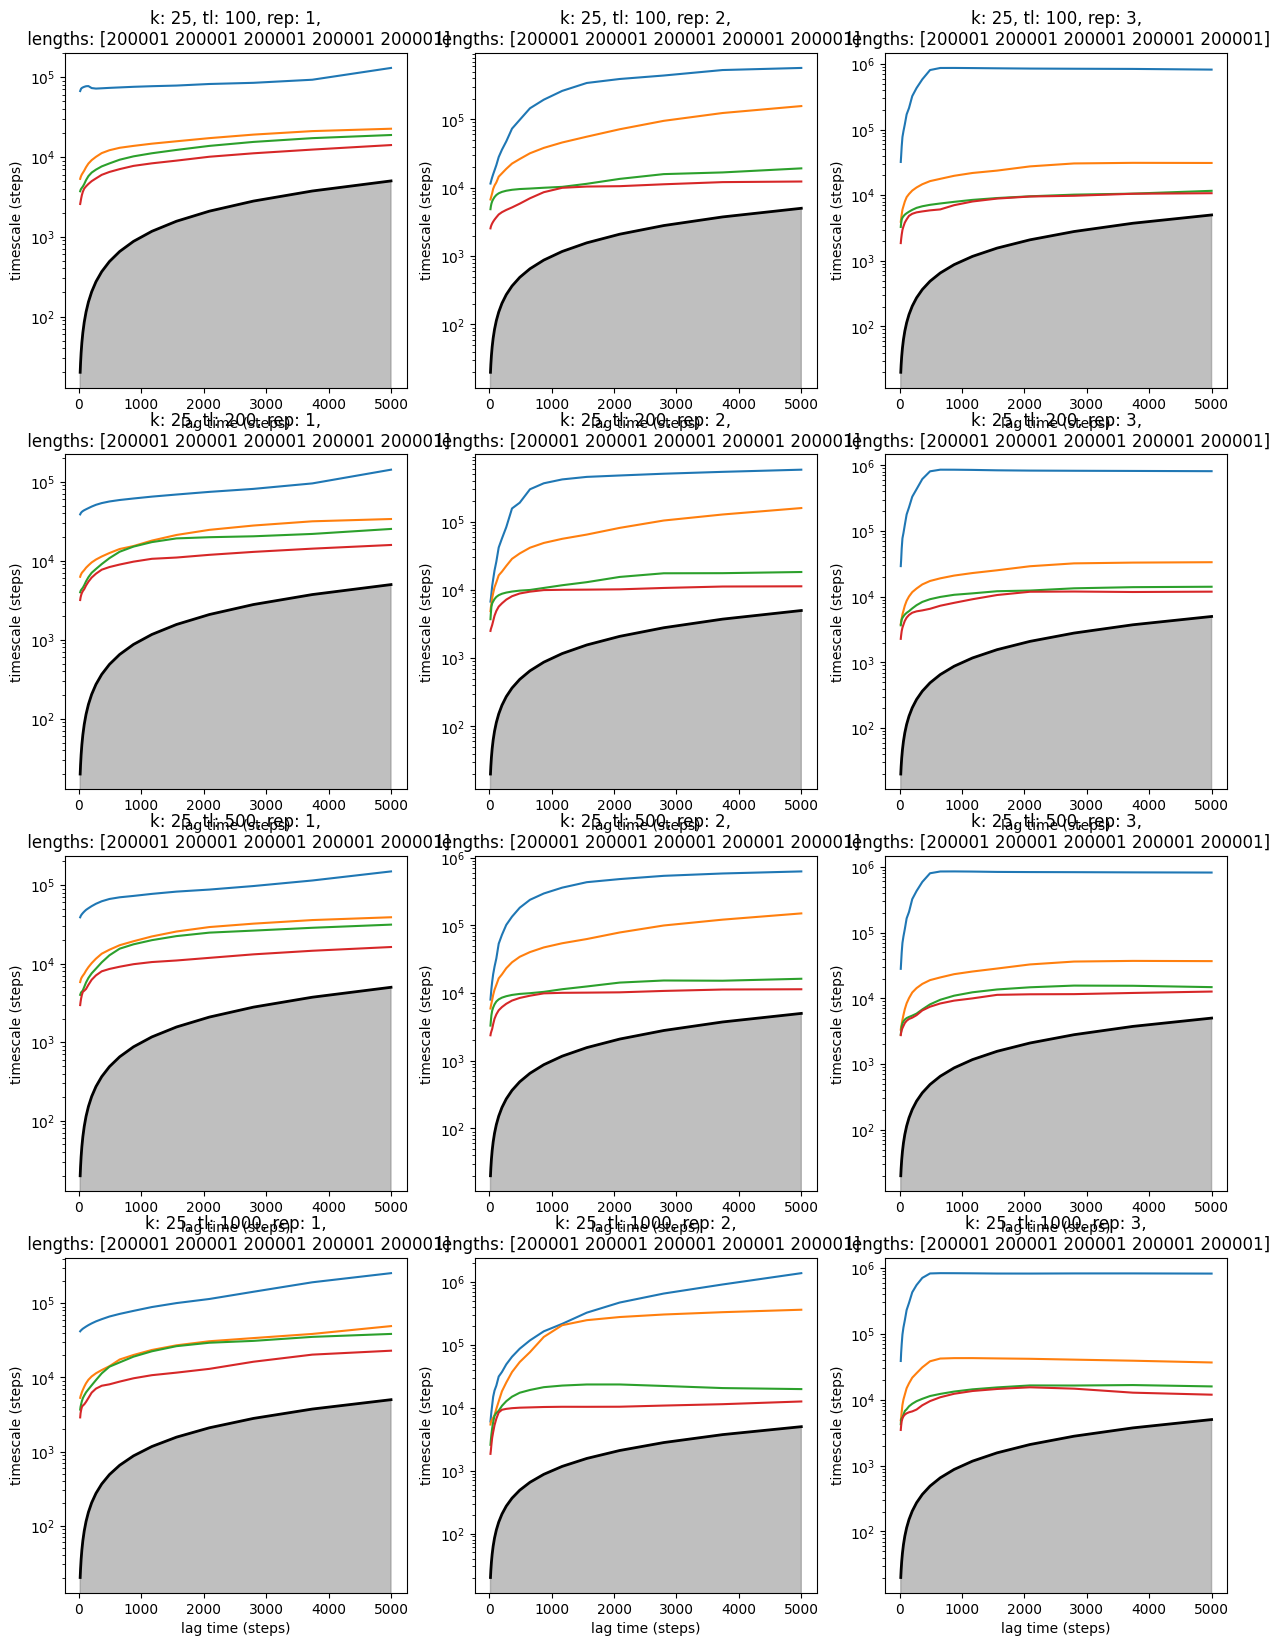

In [6]:
k=25
fig, axs = plt.subplots(4, 3, figsize=(15, 20))
for rep in range(1,4):
    for tli, tl in enumerate([100,200,500,1000]):
        ax = axs[tli][rep-1]
        dtrajs, models, its_data = load_and_plot_its(
            f't4l-{rep}/clustering/t4l-{rep}-backbone-all-chis-dihedrals-pocket-tica-lag-{tl}-tica-reduced-k-{k}-dtrajs.h5',
            ax,
            rep,
            tl,
            k
        )


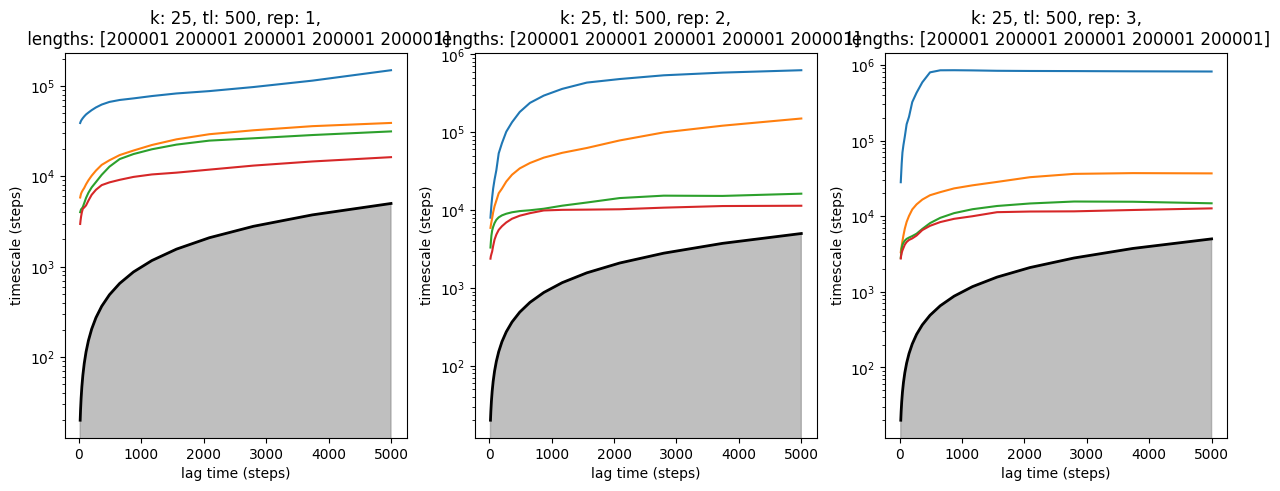

In [7]:
k=25
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
tls = [500]
for rep in range(1,4):
    for tli, tl in enumerate(tls):
        # ax = axs[tli][rep-1]
        ax = axs[rep-1]
        dtrajs, models, its_data = load_and_plot_its(
            f't4l-{rep}/clustering/t4l-{rep}-backbone-all-chis-dihedrals-pocket-tica-lag-{tl}-tica-reduced-k-{k}-dtrajs.h5',
            ax,
            rep,
            tl,
            k
        )
fig.savefig('25-center-its-plots-tica-lag-500.pdf', transparent=True)

In [5]:
from pathlib import Path
from functools import partial
from enspara.msm import builders
# chosen subset based on lags and vamp scan 
# (see other analyses for vamp)
k = 75
tica_lag = 500 
lag = 2000
for resect_to_frac in resects:
    for rep in range(1, 4):
        basep = Path(f't4l-{rep}')
        modelp = basep/'models'/f'bb-all-chis-pocket-resect-{resect_to_frac:.1f}' / \
                f'tica-{tica_lag}-msm-{lag}'/f'{k}-clusters'
        if not modelp.is_dir():
            modelp.mkdir(parents=True, exist_ok=True)
        assignp = basep/'clustering' / f'resect-{resect_to_frac:.1f}'/ \
                    f't4l-{rep}-backbone-all-chis-dihedrals-pocket-tica-lag-{tica_lag}-tica-reduced-k-{k}-dtrajs.h5'
        if not assignp.is_file():
            print(assignp, ': not found. Skipping.')
            continue
        assigns = ra.load(str(assignp))
        mlefitter = deeptime.markov.msm.MaximumLikelihoodMSM(
            lagtime=tica_lag, connectivity_threshold=1/k)
        mle = mlefitter.fit_fetch([a.astype(int) for a in assigns])
        print(modelp, 'fraction in each connected msm:', mle.state_fractions)
        mle_tprobs = mle.transition_matrix
        mle_eq_probs = mle.stationary_distribution
        mle_map = deeptime_mapping_to_mapped_dict(mle)
        mledir = modelp/'mle'
        mledir.mkdir(exist_ok=True)
        np.save(str(mledir/'tprobs.npy'), mle_tprobs)
        np.save(str(mledir/'eq-probs.npy'), mle_eq_probs)
        with (mledir/'mapping.json').open('w') as f:
            json.dump(mle_map, f)
        # normsm = msm.MSM(lag_time=tica_lag, trim=True,
                        # method=partial(builders.normalize, prior_counts=1/k, calculate_eq_probs=True))
        # normsm.fit(assigns)
        # normsmp = modelp/'norm'
        # if normsmp.is_dir():
            # for fp in normsmp.iterdir():
                # fp.unlink()
            # normsmp.rmdir()
        # normsm.save(str(normsmp), force=True)
        # get a version of eq probs that are numpy binary format at same overall path.
        # eq_probs = np.loadtxt(str(normsmp/'eq-probs.dat'))
        # np.save(str(normsmp/'eq-probs.npy'), eq_probs)


t4l-1/models/bb-all-chis-pocket-resect-0.2/tica-500-msm-2000/75-clusters fraction in each connected msm: [1.0]
t4l-2/models/bb-all-chis-pocket-resect-0.2/tica-500-msm-2000/75-clusters fraction in each connected msm: [1.0]
t4l-3/models/bb-all-chis-pocket-resect-0.2/tica-500-msm-2000/75-clusters fraction in each connected msm: [0.9333333333333333, 0.05333333333333334, 0.013333333333333334]
t4l-1/models/bb-all-chis-pocket-resect-0.4/tica-500-msm-2000/75-clusters fraction in each connected msm: [1.0]
t4l-2/models/bb-all-chis-pocket-resect-0.4/tica-500-msm-2000/75-clusters fraction in each connected msm: [0.8133333333333334, 0.18666666666666668]
t4l-3/models/bb-all-chis-pocket-resect-0.4/tica-500-msm-2000/75-clusters fraction in each connected msm: [1.0]
t4l-1/models/bb-all-chis-pocket-resect-0.6/tica-500-msm-2000/75-clusters fraction in each connected msm: [1.0]
t4l-2/models/bb-all-chis-pocket-resect-0.6/tica-500-msm-2000/75-clusters fraction in each connected msm: [1.0]
t4l-3/models/bb-al

In [ ]:
assigns = ra.load('t4l-1/clustering/t4l-1-backbone-all-chis-dihedrals-pocket-tica-lag-200-tica-reduced-k-100-dtrajs.h5')
assigns.lengths
dtrajs = list(x.astype(int) for x in assigns)
dtrajs[0]

array([56, 56, 56, ..., 20, 20, 20])

Text(0, 0.5, 'timescale (steps)')

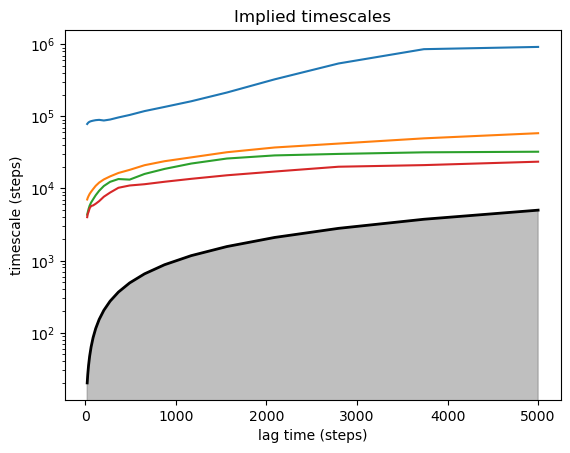

In [ ]:
lagtimes = np.geomspace(20, 5000, num=20).astype(int)
models = []
for lag in lagtimes:
    counts = TransitionCountEstimator(lagtime=lag, count_mode='sliding').fit_fetch(dtrajs)
    models.append(MaximumLikelihoodMSM().fit_fetch(counts))
its_data = implied_timescales(models, n_its=4)
fig, ax = plt.subplots(1, 1)
plot_implied_timescales(its_data, n_its=4, ax=ax)
ax.set_yscale('log')
ax.set_title('Implied timescales')
ax.set_xlabel('lag time (steps)')
ax.set_ylabel('timescale (steps)')


In [ ]:
assigns = ra.load(
    't4l-1/clustering/t4l-1-backbone-all-chis-dihedrals-pocket-tica-lag-1000-tica-reduced-k-100-dtrajs.h5')
assigns.lengths
dtrajs = list(x.astype(int) for x in assigns)
dtrajs[0]


array([35, 35, 35, ..., 27, 27, 27])

Text(0, 0.5, 'timescale (steps)')

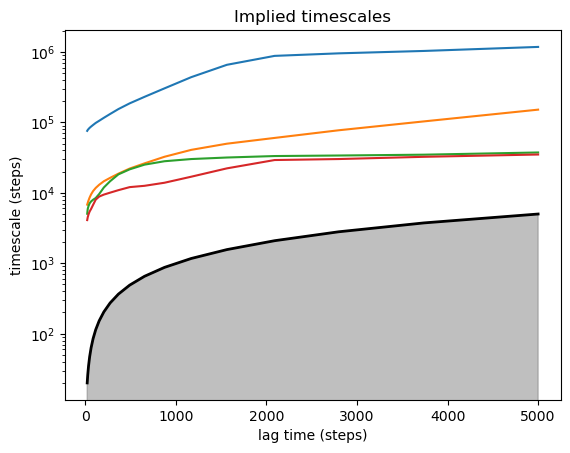

In [ ]:
lagtimes = np.geomspace(20, 5000, num=20).astype(int)
models = []
for lag in lagtimes:
    counts = TransitionCountEstimator(
        lagtime=lag, count_mode='sliding').fit_fetch(dtrajs)
    models.append(MaximumLikelihoodMSM().fit_fetch(counts))
its_data = implied_timescales(models, n_its=4)
fig, ax = plt.subplots(1, 1)
plot_implied_timescales(its_data, n_its=4, ax=ax)
ax.set_yscale('log')
ax.set_title('Implied timescales')
ax.set_xlabel('lag time (steps)')
ax.set_ylabel('timescale (steps)')


In [ ]:
assigns = ra.load(
    't4l-2/clustering/t4l-2-backbone-all-chis-dihedrals-pocket-tica-lag-1000-tica-reduced-k-100-dtrajs.h5')
assigns.lengths
dtrajs = list(x.astype(int) for x in assigns)
dtrajs[0]


array([48, 71, 71, ..., 91, 91, 91])

Text(0, 0.5, 'timescale (steps)')

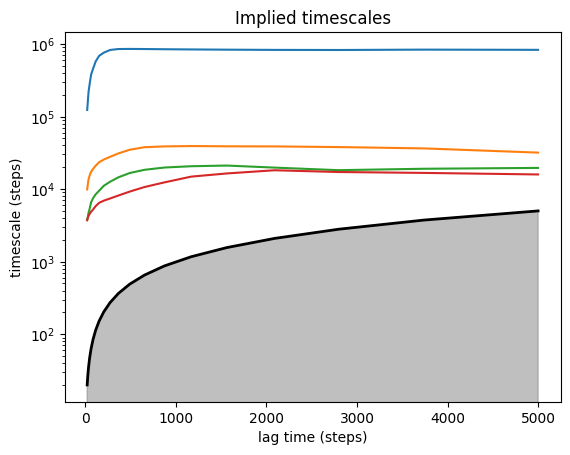

In [ ]:
lagtimes = np.geomspace(20, 5000, num=20).astype(int)
models = []
for lag in lagtimes:
    counts = TransitionCountEstimator(
        lagtime=lag, count_mode='sliding').fit_fetch(dtrajs)
    models.append(MaximumLikelihoodMSM().fit_fetch(counts))
its_data = implied_timescales(models, n_its=4)
fig, ax = plt.subplots(1, 1)
plot_implied_timescales(its_data, n_its=4, ax=ax)
ax.set_yscale('log')
ax.set_title('Implied timescales')
ax.set_xlabel('lag time (steps)')
ax.set_ylabel('timescale (steps)')


Text(0, 0.5, 'timescale (steps)')

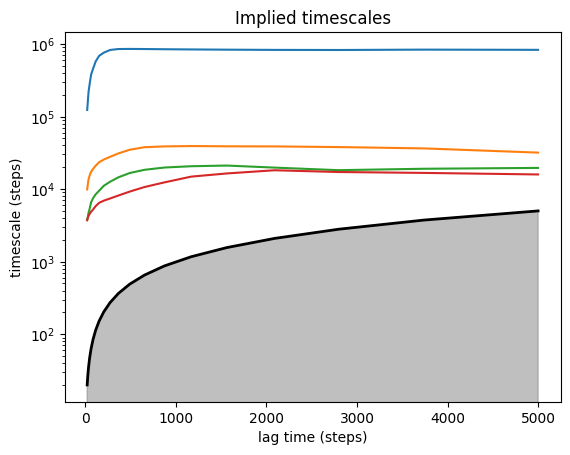

In [ ]:
assigns = ra.load(
    't4l-3/clustering/t4l-3-backbone-all-chis-dihedrals-pocket-tica-lag-1000-tica-reduced-k-100-dtrajs.h5')
assigns.lengths
dtrajs = list(x.astype(int) for x in assigns)
dtrajs[0]
lagtimes = np.geomspace(20, 5000, num=20).astype(int)
models = []
for lag in lagtimes:
    counts = TransitionCountEstimator(
        lagtime=lag, count_mode='sliding').fit_fetch(dtrajs)
    models.append(MaximumLikelihoodMSM().fit_fetch(counts))
its_data = implied_timescales(models, n_its=4)
fig, ax = plt.subplots(1, 1)
plot_implied_timescales(its_data, n_its=4, ax=ax)
ax.set_yscale('log')
ax.set_title('Implied timescales')
ax.set_xlabel('lag time (steps)')
ax.set_ylabel('timescale (steps)')
